# 4. Evaluation Metrics for Classification

How do we decide if the prediction is good or not?

## 4.1 Evaluation metrics: session overview

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('../03-classification/Telco-Customer-Churn.csv')

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce') # Invalide value would be set as NaN
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

But is the correctness of 0.8 is good or not?

## 4.2 Accuracy and dummy model

We first set the threshold as 0.5, i.e. we say the client would churn, is the score we get from the logistic regression model is bigger or equal to 0.5; otherwise not churn. We calculate the accuracy in the validation data set.

In [10]:
(y_val == churn_decision).sum() / len(y_val)

np.float64(0.8034066713981547)

We can try other thresholds, and check the accuracy with different thresholds.

In [11]:
thresholds = np.linspace(0, 1, 21)

accuracy_list = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    accuracy = (y_val == churn_decision).mean()
    print(f"{t:.2f} {accuracy:.3f}\n")
    accuracy_list.append(accuracy)


0.00 0.274

0.05 0.509

0.10 0.591

0.15 0.667

0.20 0.710

0.25 0.737

0.30 0.760

0.35 0.772

0.40 0.785

0.45 0.793

0.50 0.803

0.55 0.801

0.60 0.795

0.65 0.786

0.70 0.765

0.75 0.744

0.80 0.735

0.85 0.726

0.90 0.726

0.95 0.726

1.00 0.726



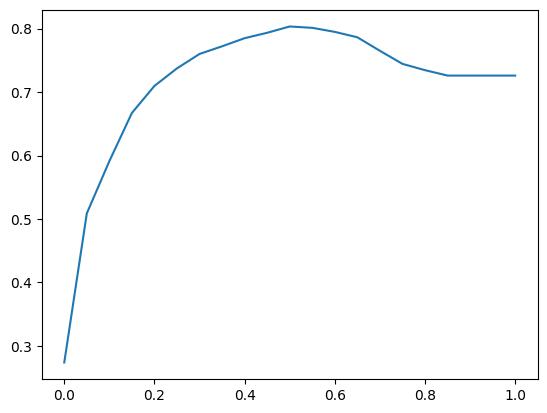

In [12]:
plt.plot(thresholds, accuracy_list)

We can also use the built-in function for calculating the accuracy.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

We take a closer look at threshold = 1. That means, we only make prediction with "churn" when the return value of logistic regression if bigger or equal to 1, i.e. equal to 1, since logistic regression always returns a value in $[0, 1]$. Otherwise we make the prediction of "not churn". Basically this dummy model tells every client would not "churn". Since the ratio in the real data of "churning" clients is small (***Class Imbalance***), the accuracy of this dummy model is not that much worse than a good model. This also indicates a problem of the accuracy as a metric.

In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1)

Counter({np.False_: 1409})

In [17]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

We take the case of "churn" as positive and "not churn" as negative. There are four possible scenerios:
* **True positive:** When the prediction is "churn" and the customer indeed churns.
* **True negative:** When the prediction is "not churn" and the customer indeed doesn't churn.
* **False positive:** When the prediction is "churn" and the customer doesn't churn.
* **False negative:** When the prediction is "not churn" and the customer indeed churns.

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
#actual_negative.shape

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)
#predict_positive.shape

In [20]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
tp, tn

(np.int64(210), np.int64(922))

In [21]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fp, fn

(np.int64(101), np.int64(176))

In [22]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [23]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

These are the metrics related to the confusion matrix.

**Precision:** Fraction of positive predictions that are correct, i.e. $precision = \frac{tp}{tp + fp}$

**Recall:** Fraction of correctly identified positive examples, i.e. $recall = \frac{tp}{\#\textit{positive true value}} = \frac{tp}{tp + fn}$

In [24]:
p = tp / (tp + fp) # 0.6752411575562701
# This means that only 67.5% of customers who would receive the promotion emails are supposed to get the promotion

In [25]:
r = tp / (tp + fn) # 0.5440414507772021
# This means the model failed to identify 1-54% = 46% of the customers who would churn

## 4.5 ROC Curves
FPR - false positive rate
$$FPR = \frac{FP}{TN + FP}$$
TPR - true positive rate
$$TPR = \frac{TP}{FN + TP}$$
We want to minimize FPR and maximize TPR. Note that TPR is the same as Recall.


In [26]:
tpr = tp / (fn + tp)
fpr = fp / (tn + fp)
tpr, fpr

(np.float64(0.5440414507772021), np.float64(0.09872922776148582))

In [27]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp, fp, fn, tn))

    

In [28]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
#df_scores

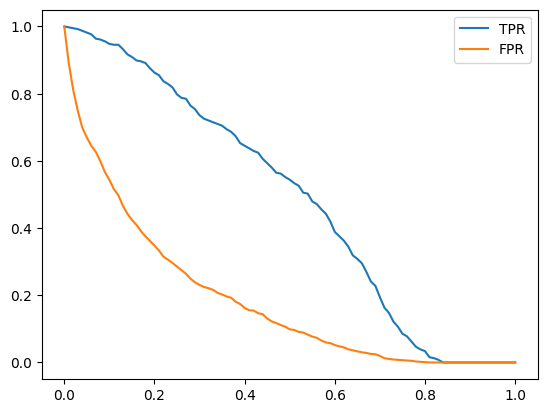

In [29]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

Next we explore this relationships for different models.

Assume we have a random model.

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [31]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t,tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [32]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

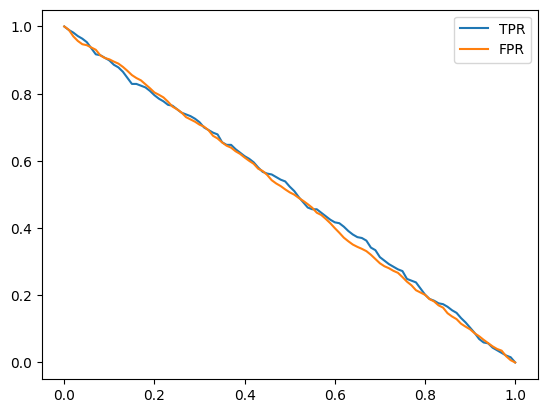

In [33]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

What about an ideal model?

In [34]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [35]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [36]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [37]:
1- y_val.mean()

np.float64(0.7260468417317246)

In [38]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [39]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

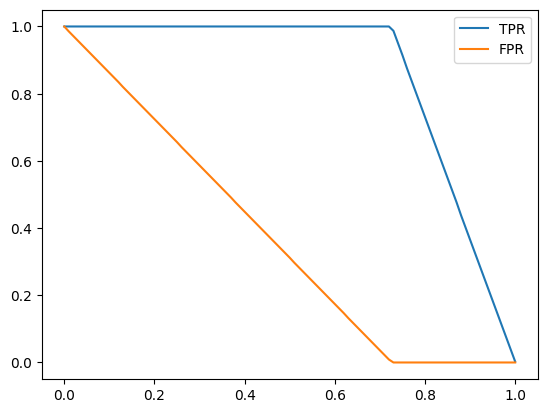

In [40]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

Put three models together.

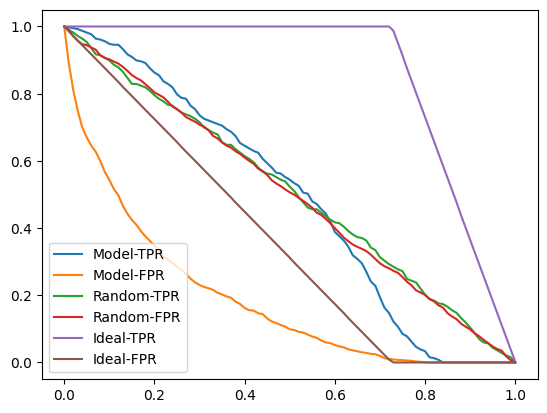

In [41]:
plt.plot(df_scores.threshold, df_scores.tpr, label='Model-TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='Model-FPR')
plt.plot(df_rand.threshold, df_rand.tpr, label='Random-TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='Random-FPR')
plt.plot(df_ideal.threshold, df_ideal.tpr, label='Ideal-TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='Ideal-FPR')
plt.legend()

Next, plot TPR against FPR.

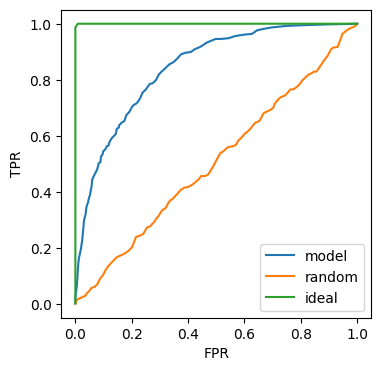

In [42]:
plt.figure(figsize=(4, 4))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [43]:
from sklearn.metrics import roc_curve

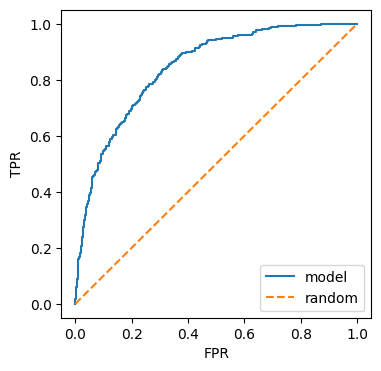

In [44]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 4.6 ROC AUC

AUC is the area under the ROC curve. For the ideal case the AUC is $1$ and for the random model $0.5$. So our model would have the AUC between $0.5$ and $1$.

In [45]:
from sklearn.metrics import auc

In [46]:
auc(fpr, tpr)

0.8438454408703447

In [48]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
roc_auc_score(y_val, y_pred)

0.8438454408703447

### Intepretation of AUC
We randomly select one sample from positive examples and one from negative examples. AUC is the probability that the randomly selected positive exmaple has higher score than the randomly selected negative example.

In [51]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [52]:
import random

In [56]:
n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.848

In [60]:
# implement with numpy
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8461)

## 4.7 Cross-Validation
A way evaluate the same model on different subsets of data.
### K-Fold Cross-Validation
We divide first the data into training data and test data. Then we divide the training data into $k$ segments. Every time we use $k-1$ parts of these data segments for training and the rest 1 segment for validation. We analyze the $k$ results from the validation statistically, i.e., calculate the mean and standard deviation of these $k$ results.

In [62]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    return dv, model

In [63]:
dv, model = train(df_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [65]:
y_pred = predict(df_val, dv, model)

In [66]:
from sklearn.model_selection import KFold

In [67]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
train_idx, val_idx = next(kfold.split(df_full_train)) # kfold.split returns a iterator

In [71]:
len(train_idx), len(val_idx), len(df_full_train)

(5070, 564, 5634)

In [72]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [81]:
from tqdm.auto import tqdm

In [82]:
# Loop inside the iterator
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.mean(scores), np.std(scores)

0it [00:00, ?it/s]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

(np.float64(0.841309816783304), np.float64(0.012352777497991931))